### Creating Multimodel RAG (Retrieval-Augmented-Generation)

##### What is RAG?
It is the process of optimizing the output of a large language model. RAG process references a knowledge base outside of its training data sources before generating a response.

**Three main components of RAG**
- Ingestion
- Retrieval
- Generation

##### What is MultiModel RAG?
Multimodel RAG is AI system that can understand different modalities like images, audio, video and text. It enables AI systems to process and integrate data from numerous modalities, such as text, audio, video, tables etc.

There are three main ways to approach the multimodel RAG:

Option 1
- Use multimodel embeddings to embed images.
- Retrieve all using similarity search.
- Pass raw images and text chunks to a multimodel LLM for an answer generation.

Option 2
- Use a multimodel LLM to produce text summaries from images.
- Embed all (summaries of images, tables and text) and retrieve text.
- Pass text chunk to an LLM for answer generation.

Option 3
- Use a multimodel LLM to produce text summaries from images.
- Embed and retrieve image summaries with a reference to the raw image.
- Pass the raw image and text chunk to a multimodal LLM for answer generation.


We will be going ahead with Option 3.

In [194]:
from dotenv import load_dotenv

load_dotenv()

True

### Extract the Data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images,Tables etc.

#### Partition PDF Tables, Text and Images

If you didn't have poppler and tesseract installed and add it to Path

In [ ]:
from unstructured.partition.pdf import partition_pdf

output_path = './content/'
file_path = output_path + 'attention.pdf'

def partition_and_chunk_pdf(file_path):
    """Partitions and chunks a PDF file into manageable pieces. 
    """
    chunks= partition_pdf(
        filename=file_path,
        infer_tables_structure=True,          # Extract tables with structure
        strategy='hi_res',                     # Mandatory to infer tables
        
        extract_image_block_types=["Image"],   # Add 'Table' to list to extract tables as images
        # image_output_dir_path=output_path,    # Directory to save images
        
        extract_image_block_to_payload=True,   # Extract metadata element containing base64 object of the image
                                                # Must when sending the image to LLMs
        
        chunking_strategy="by_title",          # Chunking strategy to use, can be 'by_title', 'basic'
        max_characters=2000,                   # Maximum number of characters per chunk
        combine_text_under_n_chars=500,        # Combine text blocks under this number of characters with previous text block
        new_after_n_chars=6000,                # New chunk after this number of characters. Hard limit.
    )
    return chunks



In [125]:
chunks = partition_and_chunk_pdf(file_path)
set([str(type(el)) for el in chunks])  # Check types of elements in the list

{"<class 'unstructured.documents.elements.CompositeElement'>"}

Unstructured creates a seprate element for tables but only have text key. It doesn't have text_to_html or text_to_markup which could be passed to LLM for summarization. Therefore we will be passing it as a text only and not required to create a seprate element for it.

In [318]:
a = set()
for chunk in chunks:
    for el in chunk.metadata.orig_elements:
        a.add(el.category)
print(a)

{'UncategorizedText', 'FigureCaption', 'Table', 'Image', 'ListItem', 'Title', 'Header', 'EmailAddress', 'Footer', 'Formula', 'NarrativeText'}


In [319]:
def get_table(chunks):
    tables = []
    for chunk in chunks:
        for el in chunk.metadata.orig_elements:
            if 'Table' in str(type(el)):
                print(el.to_dict())
                tables.append(el)
    return tables

tables = get_table(chunks)

{'type': 'Table', 'element_id': '1fc6e460-9b63-41a9-b25a-3fb051cfaa90', 'text': 'Layer Type Complexity per Layer Sequential Maximum Path Length Operations Self-Attention O(n2 · d) O(1) O(1) Recurrent O(n · d2) O(n) O(n) Convolutional O(k · n · d2) O(1) O(logk(n)) Self-Attention (restricted) O(r · n · d) O(1) O(n/r)', 'metadata': {'detection_class_prob': 0.928255021572113, 'coordinates': {'points': ((np.float64(320.3291931152344), np.float64(312.45477294921875)), (np.float64(320.3291931152344), np.float64(519.1640014648438)), (np.float64(1363.98291015625), np.float64(519.1640014648438)), (np.float64(1363.98291015625), np.float64(312.45477294921875))), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'last_modified': '2025-06-05T01:31:50', 'filetype': 'PPM', 'languages': ['eng'], 'page_number': 6}}
{'type': 'Table', 'element_id': '17bdbac8-bbc5-44ec-b655-8fb4206edde2', 'text': 'Model BLEU EN-DE EN-FR Training Cost (FLOPs) EN-DE EN-FR ByteNet [18] 23.75 Deep-Att + Pos

In [320]:
tables[2].to_dict()

{'type': 'Table',
 'element_id': '7f2cc942-b799-422c-a246-5c42f2208a33',
 'text': 'N dmodel dff h dk dv Pdrop ϵls train steps PPL (dev) BLEU params (dev) ×106 base 6 512 2048 8 64 64 0.1 0.1 100K 4.92 25.8 65 1 512 512 5.29 24.9 (A) 4 16 128 32 128 32 5.00 4.91 25.5 25.8 32 16 16 5.01 25.4 (B) 16 32 5.16 5.01 25.1 25.4 58 60 2 6.11 23.7 36 4 5.19 25.3 50 8 4.88 25.5 80 (C) 256 32 32 5.75 24.5 28 1024 128 128 4.66 26.0 168 1024 5.12 25.4 53 4096 4.75 26.2 90 0.0 5.77 24.6 (D) 0.2 0.0 4.95 4.67 25.5 25.3 0.2 5.47 25.7 (E) positional embedding instead of sinusoids 4.92 25.7',
 'metadata': {'detection_class_prob': 0.9245283007621765,
  'coordinates': {'points': ((np.float64(300.62860107421875),
     np.float64(356.70068359375)),
    (np.float64(300.62860107421875), np.float64(1062.924560546875)),
    (np.float64(1406.045654296875), np.float64(1062.924560546875)),
    (np.float64(1406.045654296875), np.float64(356.70068359375))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layou

In [321]:
len(chunks)

31

In [322]:
chunks[18].to_dict()

{'type': 'CompositeElement',
 'element_id': '7e93c44d25dd9eb8004b504423fac9c3',
 'text': '5.4 Regularization\n\nWe employ three types of regularization during training:\n\n7\n\nTable 2: The Transformer achieves better BLEU scores than previous state-of-the-art models on the English-to-German and English-to-French newstest2014 tests at a fraction of the training cost.\n\nModel BLEU EN-DE EN-FR Training Cost (FLOPs) EN-DE EN-FR ByteNet [18] 23.75 Deep-Att + PosUnk [39] 39.2 1.0 · 1020 GNMT + RL [38] 24.6 39.92 2.3 · 1019 1.4 · 1020 ConvS2S [9] 25.16 40.46 9.6 · 1018 1.5 · 1020 MoE [32] 26.03 40.56 2.0 · 1019 1.2 · 1020 Deep-Att + PosUnk Ensemble [39] 40.4 8.0 · 1020 GNMT + RL Ensemble [38] 26.30 41.16 1.8 · 1020 1.1 · 1021 ConvS2S Ensemble [9] 26.36 41.29 7.7 · 1019 1.2 · 1021 Transformer (base model) 27.3 38.1 3.3 · 1018 Transformer (big) 28.4 41.8 2.3 · 1019\n\nResidual Dropout We apply dropout [33] to the output of each sub-layer, before it is added to the sub-layer input and normaliz

In [323]:
## check the elements in chunk 5
chunks[5].metadata.orig_elements

In [133]:
## extract images from chunk
elements = chunks[5].metadata.orig_elements
chunk_image = [el for el in elements if 'Image' in str(type(el))]
chunk_image[0].to_dict()

{'type': 'Image',
 'element_id': 'c18ea7a2-57a6-400e-bac8-3fd304235777',
 'text': 'Output Probabilities Add & Norm Feed Forward Add & Norm Multi-Head Attention a, Add & Norm Add & Norm Feed Forward Nx | -+CAgc8 Norm) Add & Norm Masked Multi-Head Multi-Head Attention Attention Se a, ee a, Positional Positional Encoding @ © @ Encoding Input Output Embedding Embedding Inputs Outputs (shifted right)',
 'metadata': {'coordinates': {'points': ((np.float64(545.9972222222221),
     np.float64(200.00555555555542)),
    (np.float64(545.9972222222221), np.float64(1095.6055555555556)),
    (np.float64(1153.997222222222), np.float64(1095.6055555555556)),
    (np.float64(1153.997222222222), np.float64(200.00555555555542))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-06-05T01:31:50',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 3,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0

In [324]:
## saving the text 
texts = [chunk for chunk in chunks if 'CompositeElement' in str(type(chunk))]

In [ ]:
def save_texts(chunks):
    """
    Extracts texts from the list of chunks.
    """
    texts = [chunk for chunk in chunks if 'CompositeElement' in str(type(chunk))]

    return texts

In [331]:
## save text and tables
texts = save_texts(chunks)

In [332]:
print(f"Number of text chunks: {len(texts)}")

Number of text chunks: 31


In [140]:
## getting the images from the CompositeElement object

def get_image_base64(chunks):
    image_b64 = []
    for chunk in chunks:
        chunk_el = chunk.metadata.orig_elements
        for el in chunk_el:
            if 'Image' in str(type(el)):
                image_b64.append(el.metadata.image_base64)
    return image_b64

images = get_image_base64(chunks)

##### Check the Images

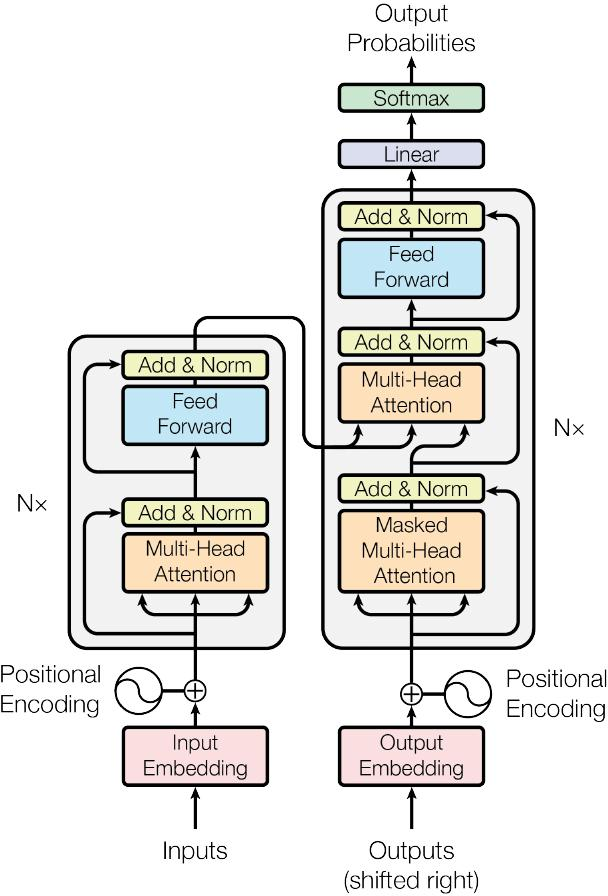

In [99]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    ## decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # display the image
    display(Image(data=image_data))
    
display_base64_image(images[0])

### Summarizing the data

In [171]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [189]:
## Summarizing Text

## Create a Groq model
model = ChatOpenAI(temperature=0.5, model='gpt-4o-mini')

## Create a prompt template for summarization
prompt = '''
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything similar.
just give the summary as it is.

Table or text chunk: {element}
'''

prompt_template = ChatPromptTemplate.from_template(prompt)

## chain the prompt with the Groq model and output parser
chain = prompt_template | model | StrOutputParser()


In [ ]:
## Summarize text
text_summaries = chain.batch(texts,{"max_concurrency":3})

In [187]:
text_summaries

['The document is a citation for the paper "Attention Is All You Need," authored by Ashish Vaswani and colleagues from Google Brain and Google Research, as well as the University of Toronto. It includes permission from Google to reproduce tables and figures for journalistic or scholarly use, provided proper attribution is given.',
 'The paper introduces the Transformer, a novel network architecture for sequence transduction that relies solely on attention mechanisms, eliminating the need for recurrent or convolutional layers. It outperforms existing models in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French, with significantly reduced training time and costs. The Transformer also demonstrates strong generalization capabilities in other tasks, such as English constituency parsing.',
 "The table outlines the contributions of various individuals to the development of Transformer models, highlighting their roles in proposing ide

In [190]:
## Summarizing images

prompt_template_image = """Describe the image in detail. Be specific about the architecture, graphs, plots such as bar plot"""

messages = [
    ("user",
        [
            {"type":"text","text":prompt_template_image},
            {"type":"image_url","image_url":{"url":"data:image/jpeg;base64,{image}"},},
        ],
    )
]

prompt_image = ChatPromptTemplate.from_messages(messages)

chain_image = prompt_image | model | StrOutputParser()

In [191]:
image_summaries = chain_image.batch(images)

In [ ]:
image_summaries

['The image depicts a diagram of a Transformer architecture, commonly used in natural language processing and machine learning. Here’s a detailed description:\n\n### Structure Overview\n- **Two Main Sections**: The diagram is divided into two main parts: the **Encoder** (left) and the **Decoder** (right).\n- **Layers**: Both sections feature a series of stacked layers, indicated by "N" which represents the number of layers (Nx).\n\n### Encoder\n- **Input Embedding**: At the bottom, there is an **Input Embedding** block that receives the input data.\n- **Positional Encoding**: Above the input embedding, a **Positional Encoding** is added, which helps the model understand the order of the input tokens.\n- **Layer Components**:\n  - Each layer consists of:\n    - **Multi-Head Attention**: This block allows the model to focus on different parts of the input simultaneously.\n    - **Add & Norm**: After the attention mechanism, there is an "Add & Norm" block that adds the input to the output

In [193]:
print(image_summaries[0])

The image depicts a diagram of a Transformer architecture, commonly used in natural language processing and machine learning. Here’s a detailed description:

### Structure Overview
- **Two Main Sections**: The diagram is divided into two main parts: the **Encoder** (left) and the **Decoder** (right).
- **Layers**: Both sections feature a series of stacked layers, indicated by "N" which represents the number of layers (Nx).

### Encoder
- **Input Embedding**: At the bottom, there is an **Input Embedding** block that receives the input data.
- **Positional Encoding**: Above the input embedding, a **Positional Encoding** is added, which helps the model understand the order of the input tokens.
- **Layer Components**:
  - Each layer consists of:
    - **Multi-Head Attention**: This block allows the model to focus on different parts of the input simultaneously.
    - **Add & Norm**: After the attention mechanism, there is an "Add & Norm" block that adds the input to the output of the attent

## Load data and summaries to VectoreStore

In [210]:
import uuid
import os
from langchain_astradb import AstraDBVectorStore
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [273]:
token = os.getenv('ASTRA_DB_APPLICATION_TOKEN')
namespace = os.getenv('ASTRA_DB_KEYSPACE')
endpoint = os.getenv('ASTRA_DB_API_ENDPOINT')
embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [275]:
## The vector store to index the summary chunks
vector_store = AstraDBVectorStore(
    embedding=embedding,
    collection_name="RAG",
    api_endpoint=endpoint,
    token=token,
    namespace=namespace,
)

## The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

## The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vector_store,  ## The vector store to index the summary chunks
    docstore=store,            ## The storage layer for the parent documents
    id_key=id_key,
)



### Loading the Summaries and Linking to the original data

In [ ]:
"""
## adding the texts
## Generate unique IDs for each text chunk 
doc_ids = [str(uuid.uuid4()) for _ in texts]
## Creating Langchain Document objects for each text_summary chunk
summary_texts = [Document(page_content=summary,metadata={id_key:doc_ids[i]}) for i,summary in enumerate(text_summaries)]

## indexing the documents in vector store and document store
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids,texts)))

## adding images summaries
img_ids = [str(uuid.uuid4()) for _ in images]
## Creating Langchain Document objects for each image_summary chunk
summary_images = [Document(page_content=summary,metadata={id_key:img_ids[i]}) for i,summary in enumerate(image_summaries)]
## indexing the documents in vector store and document store
retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(img_ids,images)))
## Now the retriever is ready to use
"""

In [276]:
## adding image summries
def loading_summaries_to_vector_store(retriever, chunks, chunk_summary):
    """
        Generate ids for each chunk, create langchain document object for each summry chunk.
        Indexing the summary in vector store and document in docsotre.
    """
    ## generate unique id for each chunk
    doc_ids = [str(uuid.uuid4()) for _ in texts]
    ## Creating Langchain Document objects for each text_summary chunk
    summary_texts = [Document(page_content=summary,metadata={id_key:doc_ids[i]}) for i,summary in enumerate(chunk_summary)]
    
    ## indexing the documents in vector store and document store
    retriever.vectorstore.add_documents(summary_texts)
    retriever.docstore.mset(list(zip(doc_ids,chunks)))

In [277]:
## adding text summaries to vector store and document store
loading_summaries_to_vector_store(retriever,texts,text_summaries)
## adding image summaries to vector store and document store
loading_summaries_to_vector_store(retriever,images,image_summaries)
## Now the retriever is ready to use

In [281]:
doc = retriever.invoke("Explain scaled dot-product attention?")
doc

 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIAAU4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8S+Ofj658P6toGm6ZKVuraZdSmGSAwUkIhx1B+fI+le2186/HjwxY2Gr6VqpaWe91W8f7RJI3AjURqkagYAAH4nJJNAHv+l6jb6vpVpqVo263uoVmjP+ywyPx5

In [283]:
for d in doc:
    print(d)

3.2.1 Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute the matrix of outputs as:

Attention(Q,K,V ) = softmax( QKT √ dk )V (1)

The two most commonly used attention functions are additive attention [2], and dot-product (multi- plicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor 1√ of . Additive attention computes the compatibility function using a feed-forward network with dk a single hidden layer. While the two are similar in theoretical complexity, dot-product

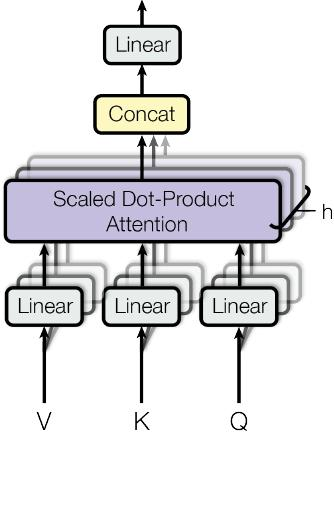

In [285]:
display_base64_image(doc[2])

In [266]:
for d in doc:
    print(d)

3

2023

2

0

2

g u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0

7

1

:

v

arXiv

i

X

r

a

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

Attention Is All You Need

Ashish Vaswani∗

Google Brain

avaswani@google.com

Noam Shazeer∗ Google Brain noam@google.com

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗

Google Research usz@google.com

Llion Jones∗

Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com
3.2 Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum

3

Scaled Dot-Product Attention

Multi-Head Attention

Linear

Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Atten

### RAG Pipeline

In [306]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode

def parse_docs(docs):
    """Parses the retrieved documents to return a dictionary with text and images."""
    image_doc = []
    text_doc = []
    for doc in docs:
        try:
            ## Attempt to decode the document as an image
            b64decode(doc)
            ## If successful, append to image_doc
            image_doc.append(doc)
        ## Raises binascii.Error if not a base64
        except Exception as e:
            ## If decoding fails, treat it as text
            text_doc.append(doc)
    return {"images":image_doc,"text":text_doc}

def built_prompt(kwargs):
    """ Builds the prompt for the model using the context and question."""
    
    ## extracting the context dictionary
    docs_by_type = kwargs['context']
    ## extracting the question
    user_question = kwargs['question']
    
    ## If length of text documents is greater than 0, concatenate the text
    context_text = ""
    if len(docs_by_type['text']) > 0:
        for text_element in docs_by_type["text"]:
            context_text +=text_element.text
    
    ## Create a prompt with context including the images
    prompt_template = f"""
    Answer the question based only on the following context, which can include text and images.
    Context: {context_text}
    Question: {user_question}"""
    
    
    prompt_content = [{"type":"text","text":prompt_template}]
    
    ## If there are images, add them to the prompt
    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {"type":"image_url","image_url":{"url":f"data:image/jpeg;base64,{image}"},                 }
            )
            
    ## Return the prompt content
    return ChatPromptTemplate.from_messages(
        [HumanMessage(content=prompt_content)]
    )
    

output_chain = (
    {
        ## Retriver will retrieve returns the retrieve document which we saw above when we invoked the retriever
        ## Then that will be passed to the parse_docs which will go over each document and parse it into text and images
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    ## build_prompt will get the context which is a dictionary with text and images, and the question
    | RunnableLambda(built_prompt)
    | model
    | StrOutputParser()
)

## building the chain with the source reference
## This will return a dictionary with the context, question, and the response from the model
chain_with_source = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response = (
        RunnableLambda(built_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

        

In [293]:
response = output_chain.invoke("What do the authors mean by 'attention'?")

print(response)

In the context provided, 'attention' refers to a mechanism that maps a query and a set of key-value pairs to an output. This output is computed as a weighted sum of the values, where the weights are determined by a compatibility function that compares the query with the corresponding keys. The attention mechanism allows the model to focus on specific parts of the input data, effectively enabling it to capture relationships and dependencies between different elements in the data, such as long-distance dependencies in sentences or anaphora resolution in language processing. The authors describe two types of attention: Scaled Dot-Product Attention and Multi-Head Attention, which involves running multiple attention functions in parallel to capture different aspects of the input.


In [316]:
response = chain_with_source.invoke("Explain scaled dot-product attention?")

Response: Scaled dot-product attention is a mechanism used in neural networks to focus on certain parts of the input data. Here’s a breakdown of how it works:

1. **Input**: The input consists of three components: 
   - **Queries (Q)**: Represent the information to focus on.
   - **Keys (K)**: Match against the queries to find relevant information.
   - **Values (V)**: The actual data linked to the keys.

2. **Dot Product Calculation**: The first step involves calculating the dot product of the queries and keys. This measures the compatibility or similarity between the two.

3. **Scaling**: The resulting dot products are scaled by dividing them by the square root of the dimension of the keys (\( \sqrt{d_k} \)). This scaling ensures that the values do not become excessively large, which can adversely affect the gradient during optimization.

4. **Softmax Function**: The scaled dot products are passed through a softmax function to convert the scores into probabilities (weights) that sum 

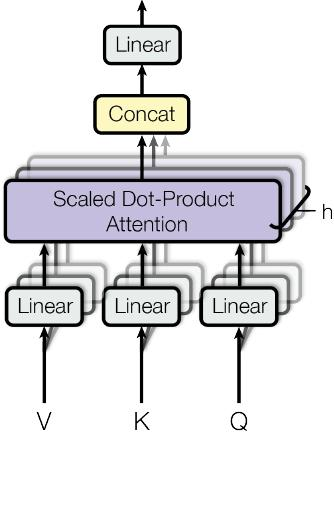

In [ ]:
## Print the response and source documents
print("Response:", response['response'],"\n")
print("-"*80,"\n\nSource Documents:")
## Print the source text
for text in response['context']['text']:
    print("Page Number:", text.metadata.page_number)
    print(text.text)
    print("\n","-"*80,"\n")
## Source Images
for image in response['context']['images']:
    display_base64_image(image)